# TabTransformer

https://arxiv.org/abs/2106.11959v2

In [1]:
from pydantic.dataclasses import dataclass
from dataclasses import asdict

import matplotlib.pyplot as plt

import torch
from torch import nn, optim, tensor
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from torchvision import transforms as T
import torchvision.transforms.functional as TF
from functools import partial

import fastcore.all as fc
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset
import tiktoken

from miniai.datasets import * 
from miniai.activations import *
from miniai.learner import *
from miniai.conv import * 
from miniai.resnet import *
from miniai.init import * 
from miniai.sgd import *
from miniai.augment import * 

In [2]:
from IPython.core.debugger import set_trace

In [3]:
set_seed(42)

In [4]:
@dataclass
class Config(BaseConfig):
    n_cont: int = 4
    cont_embed: int = 12 # Fixed to make total embedding dimension divisible by n_heads

    n_heads: int = 16    
    n_layers: int = 12
    n_classes: int = 2
    fanout = 4

In [5]:
conf = Config(ds='lewtun/titanic', arch='TabXformer', project='TabXformer', lr=1e-3, batch_size=2)
asdict(conf)

{'ds': 'lewtun/titanic',
 'arch': 'TabXformer',
 'project': 'TabXformer',
 'epochs': 5,
 'lr': 0.001,
 'batch_size': 2,
 'bias': True,
 'model_path': 'models',
 'save': False,
 'max_to_keep': 1,
 'attn_dropout': 0.0,
 'dropout': 0.01,
 'n_cont': 4,
 'cont_embed': 12,
 'n_heads': 16,
 'n_layers': 12,
 'n_classes': 2}

In [6]:
dsd = load_dataset(conf.ds)

Found cached dataset parquet (/home/leonardourbina/.cache/huggingface/datasets/lewtun___parquet/lewtun--titanic-e7f4384c383d828b/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
dsd

DatasetDict({
    test: Dataset({
        features: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
        num_rows: 418
    })
    train: Dataset({
        features: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
        num_rows: 891
    })
})

In [8]:
ds_train, ds_valid = dsd['train'], dsd['test']
ds_train

Dataset({
    features: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
    num_rows: 891
})

In [9]:
set(ds_train['Pclass']).union(set(ds_valid['Pclass']))

{1, 2, 3}

In [10]:
import math

def replace_nones(xs):
    return [x or -1 for x in xs]

def categorize(labels):
    mapping = {name: idx for idx, name in enumerate(labels)}
    def cats2int(cats):
        return tensor([mapping[cat] for cat in cats])
    return cats2int

categorical_fields = {
    'Pclass': categorize(set(ds_train['Pclass']).union(set(ds_valid['Pclass']))),
    'Sex': categorize(set(ds_train['Sex']).union(set(ds_valid['Sex']))),
    'Cabin': categorize(set(ds_train['Cabin']).union(set(ds_valid['Cabin']))),
    'Embarked': categorize(set(ds_train['Embarked'])), 
}

cat_features = {
    name: len(set(ds_train[name])) for name in categorical_fields
}

cont_fields = ['Fare', 'Age', 'Parch', 'SibSp']

def get_n_embed(cat_features, conf: Config):
    return sum([int(math.log2(c) + 1.5) for c in cat_features.values()]) + conf.cont_embed * conf.n_cont

def xform_categorical_fields(batch):
    return {name: xform(batch[name]).to(device) for name, xform in categorical_fields.items()}

def xform_cont_fields(batch):
    values = [replace_nones(o) for o in (batch[name] for name in cont_fields)]
    return tensor(values, dtype=torch.float32).permute(1, 0).to(device)

def get_label(batch):
    return tensor(batch['Survived']).to(device)

In [11]:
cat_features

{'Pclass': 3, 'Sex': 2, 'Cabin': 148, 'Embarked': 4}

In [12]:
conf.n_cont

4

In [13]:
n_embed = get_n_embed(cat_features, conf)
print(n_embed, conf.n_heads, n_embed//conf.n_heads)
assert n_embed % conf.n_heads == 0

64 16 4


In [14]:
def transform(batch):
    result = xform_categorical_fields(batch)
    result['Cont'] = xform_cont_fields(batch)
    result['Survived'] = get_label(batch)
    return result

In [15]:
tds_train = dsd['train'].with_transform(transform)
tds_valid = dsd['test'].with_transform(transform)

dl_train = DataLoader(tds_train, batch_size=conf.batch_size, shuffle=True)
dl_valid = DataLoader(tds_valid, batch_size=conf.batch_size*2)

dls = DataLoaders(dl_train, dl_valid)

# Model

In [16]:
class BatchFormatCB(Callback):
    def before_batch(self, learn: Learner):
        x_cont = learn.batch.pop('Cont')
        yb = learn.batch.pop('Survived')
        learn.batch = (learn.batch, x_cont), yb

In [17]:
import math

class TabEmbedding(nn.Module):
    def __init__(self, cat_features, n_cont, cont_embed):
        super().__init__()
        self.cont_embedding = nn.Linear(n_cont, n_cont*cont_embed)
        self.cat_embedding_dict = nn.ModuleDict({
            name: nn.Embedding(n_features, int(math.log2(n_features) + 1.5)) 
            for name, n_features in cat_features.items() })
        
    def forward(self, x):
        x_cat, x_cont = x
        cat_tkns = torch.cat([self.cat_embedding_dict[name](o) for name,o in x_cat.items()], dim=1)
        cont_tkns = self.cont_embedding(x_cont)
        return torch.cat((cat_tkns, cont_tkns), dim=1)

In [18]:
class Block(nn.Module):
    def __init__(self, n_embed, num_heads, fanout, dropout):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embed)
        self.attn = nn.MultiheadAttention(n_embed, num_heads, dropout=dropout)
        self.ln2 = nn.LayerNorm(n_embed)
        self.mlp = nn.Sequential(
            nn.Linear(n_embed, n_embed*fanout),
            conf.act(),
            nn.Dropout(p=dropout),
            nn.Linear(n_embed*fanout, n_embed),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        z = self.ln1(x)
        x1, _ = self.attn(query=z, key=z, value=z)
        x1 += x
        return x1 + self.mlp(self.ln2(x1))     

In [19]:
class TabTransformer(nn.Module):
    def __init__(self, cat_features, conf: Config):
        super().__init__()
        self.conf = conf
        self.tab_embedding = TabEmbedding(cat_features, conf.n_cont, conf.cont_embed)
        n_embed = get_n_embed(cat_features, conf)
        self.blocks = nn.Sequential(*[Block(n_embed, conf.n_heads, conf.fanout, conf.dropout)])
        self.classifier_head = nn.Linear(n_embed, conf.n_classes)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.kaiming_normal_(module.weight, a=self.conf.leak)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0., std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)        

    def forward(self, x):
        x = self.tab_embedding(x)
        x = self.blocks(x)
        return self.classifier_head(x)

In [20]:
m = TabTransformer(cat_features, conf).to(device)

In [21]:
xb = next(iter(dls.train))
x_cont = xb.pop('Cont')
yb = xb.pop('Survived')
xb = (xb, x_cont)
m(xb).shape

torch.Size([2, 2])

# Training

In [22]:
model = TabTransformer(cat_features, conf).to(device)
tmax = len(dls.train) * conf.epochs
wand = WandBCB(conf)
sched = BatchSchedCB(partial(optim.lr_scheduler.OneCycleLR, max_lr=conf.lr, total_steps=tmax))

cbs = [MetricsCB(), ProgressCB(plot=True), sched]
learn = Learner(model, dls, loss_func=F.cross_entropy, cbs=[BatchFormatCB()], opt_func=partial(optim.AdamW, betas=conf.betas))

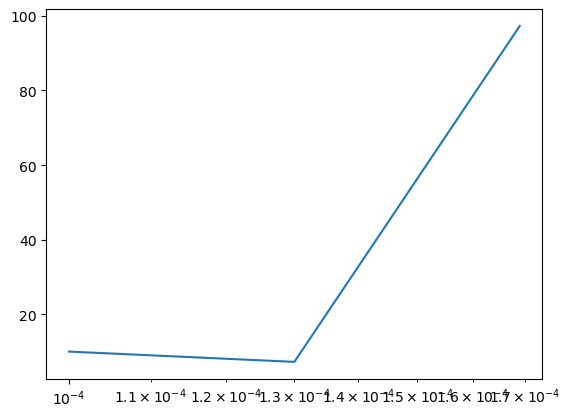

In [23]:
learn.lr_find(start_lr=1e-4) #1e-3

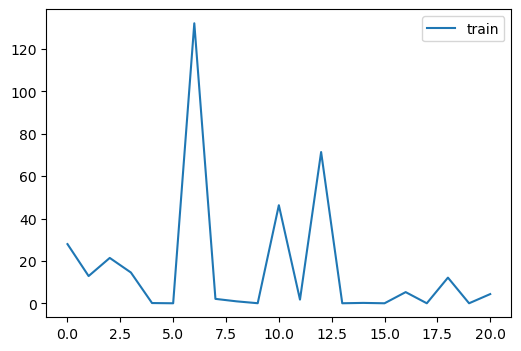

/home/conda/feedstock_root/build_artifacts/pytorch-recipe_1680557665316/work/aten/src/ATen/native/cuda/Indexing.cu:1093: indexSelectSmallIndex: block: [0,0,0], thread: [0,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/home/conda/feedstock_root/build_artifacts/pytorch-recipe_1680557665316/work/aten/src/ATen/native/cuda/Indexing.cu:1093: indexSelectSmallIndex: block: [0,0,0], thread: [1,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/home/conda/feedstock_root/build_artifacts/pytorch-recipe_1680557665316/work/aten/src/ATen/native/cuda/Indexing.cu:1093: indexSelectSmallIndex: block: [0,0,0], thread: [2,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/home/conda/feedstock_root/build_artifacts/pytorch-recipe_1680557665316/work/aten/src/ATen/native/cuda/Indexing.cu:1093: indexSelectSmallIndex: block: [0,0,0], thread: [3,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/home/conda/feedstock_root/build_artifacts/pytorch-recipe_1680557665316/work/aten/src/ATen/native/cuda/I

RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

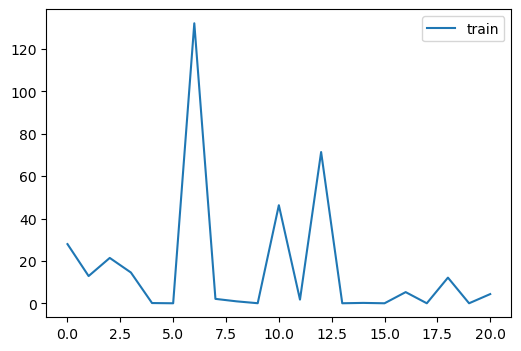

In [24]:
learn.fit(conf.epochs, cbs=cbs)